> Pacotes necessários

In [207]:
import scipy
from PIL import Image
import numpy as np
import os
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import importlib

> Esta célula trata dos plots dos datasets com e sem preditions e a função que trata de fazer o parse do dataset

In [208]:
def plot_tagged_data(row,col,n_row,n_col,X,Y,parameters): 
    fig=plt.figure(figsize=(row,col))
    
    l,cache = feed_forward(X.T,parameters,activation_function)
    for n in range(row*col):
        img=np.reshape(X[n],(n_row,n_col))
        fig.add_subplot(row, col, n+1)
           
        if(l[0][n]>0.5):
    
            plt.imshow(img,interpolation='none',cmap='RdPu')
        else:
            plt.imshow(img,interpolation='none',cmap='cool')               
    plt.show()
    
def read_asc_data(filename):    
    f= open(filename,'r') 
    tmp_str=f.readline()
    tmp_arr=tmp_str[:-1].split(' ')
    N=int(tmp_arr[0]);n_row=int(tmp_arr[1]);n_col=int(tmp_arr[2])
    data=np.zeros([N,n_row*n_col+1])
    for n in range(N):
        tmp_str=f.readline()
        tmp_arr=tmp_str[:-1].split(' ')       
        for i in range(n_row*n_col+1):
            data[n][i]=int(tmp_arr[i])
    f.close() 
    return N,n_row,n_col,data

> Esta célula corre todas as funções de ativação e as suas derivadas

In [209]:
# sigmoid function
def sigmoid(z):
    s = 1 / (1 + np.exp(-z));
    return s;

# relu function
def relu(z):
    return np.where( z <= 0, 0 , z)

#derivada sigmoid
def der_sigmoid(z):
   return sigmoid(1-sigmoid(z))

#derivada tangente hiperbólica
def der_tanh(z):
    return (1-np.power(z,2))

#derivada relu
def der_relu(z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

#leaky_relu function
def leaky_relu(z):
    return np.where( z <= 0, 0.01*z, z)

#derivada leaky_relu
def der_leaky_relu(z):
    z[z<=0]=0.01
    z[z>0]=1
    return z

#normalization
def normalization(ew):
    return(ew/np.linalg.norm(ew,2))

> Esta célula inicializa os parãmetros de uma rede neuronal, neste caso temos apenas dois layers

> Input -> Hidden Layer -> Output


In [210]:
# size of the fst and the last layer, and the hidden layer
# assuming 1 hidden layer
def inicializar_parameters(n_x,n_h,n_y):
    
    #w1 = np.zeros((n_h,n_x))
    #w1 = normalization(w1)
    w1 = np.random.randn(n_h,n_x) * 0.01;
    b1 = np.zeros((n_h,1));
    
    #w2 = np.zeros((n_y,n_h))
    #w2 = normalization(w2)
    w2 = np.random.randn(n_y,n_h) * 0.01;
    b2 = np.zeros((n_y,1));

    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }

    return parameters;


> Esta célula faz o feed forward da rede, neste caso temos que especificar as funções de ativação

> Input -> Função linear(z1) -> Função de Ativação -> Função linear(Z2) -> Função de Ativação(Sigmoid) (output)

In [211]:
# i use the non-linear activation function called than, in the output layer i use sigmoid, cause this is a binary classification problem.
def feed_forward(X,parameters,activation):
    
    
    w1 = parameters["w1"];
    b1 = parameters["b1"];
    w2 = parameters["w2"];
    b2 = parameters["b2"];

    #feed_foward
    Z1 = np.dot(w1,X) + b1; 

    
    if(activation == "tanh"):
        A1 = np.tanh(Z1);
    elif(activation == "relu"):
        A1 = relu(Z1);
    elif(activation == "sigmoid"):
        A1 = sigmoid(Z1);
    elif(activation == "leaky_relu"):
        A1 = leaky_relu(Z1);
        
    Z2 = np.dot(w2,A1) + b2;
    A2 = sigmoid(Z2);

    cache = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
    }

    return A2, cache;

> Função custo

In [212]:
def calculate_cost(A2,Yt):
    #para não estar a fazer log de 0 acrescenta-se um teta
    e = 0.000000001
    Cost = - np.sum(np.dot(Yt, np.log(A2+e).T) + np.dot(1 - Yt, np.log(1 - A2+e).T)) /m;  #cost function

    return Cost;


> Back propagation da rede, preciso as funções de ativação

In [213]:
def back_propagation(X,Y,cache,parameters,activation):

    A1 = cache["A1"];
    w1 = parameters["w1"];
    w2 = parameters["w2"];
    A2 = cache["A2"];
    
    dZ2 = A2 - Y;
    dW2 = np.dot(dZ2,A1.T)/m;
    dB2 = np.sum(dZ2, axis=1, keepdims = True)/m;
    
    if(activation == "relu"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2), der_relu(A1));
    if(activation == "tanh"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2), 1 - np.power(A1, 2));
    if(activation == "sigmoid"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2),der_sigmoid(A1));
    if(activation == "leaky_relu"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2), der_leaky_relu(A1));
    dW1 = np.dot(dZ1,X.T)/m;
    dB1 = np.sum(dZ1,axis = 1, keepdims = True)/m;

    grads = {
        "dW2" : dW2,
        "dB2" : dB2,
        "dW1" : dW1,
        "dB1" : dB1
    }

    return grads;


> Otimização de parâmetros, feito após ter corrido o back propagation, e obtido os respetivos gradientes

In [214]:
def otimize_parameters(parameters,grads,learning_rate):
    
    w1 = parameters["w1"];
    w2 = parameters["w2"];
    b1 = parameters["b1"];
    b2 = parameters["b2"];

    
    dW2 = grads["dW2"];
    dB2 = grads["dB2"];
    dW1 = grads["dW1"];
    dB1 = grads["dB1"];

    #uptade de parameters
    w2 = w2 - learning_rate * dW2;
    w1 = w1 - learning_rate * dW1;
    b1 = b1 - learning_rate * dB1;
    b2 = b2 - learning_rate * dB2;

    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }

    return parameters;

In [215]:
def model(n_h,number_iterations,learning_rate,activation):

    np.random.seed(3) # we set up a seed so that your output matches ours although the initialization is random.
    parameters = inicializar_parameters(Xt.shape[0],n_h,Yt.shape[0]);
    parametersval = inicializar_parameters(Xval.shape[0],n_h,Yval.shape[0]);
    
    #previous_cost vai ser similar a um eraly stopping neste problema, qd o custo não diminuir em 100 epochs para de treinar
    previous_cost = 1e3
    cost_arr=[]
    costval_arr=[]
    
    for i in range(0,number_iterations):

        A2, cache = feed_forward(Xt,parameters,activation);
        grads = back_propagation(Xt,Yt,cache,parameters,activation);
        parameters = otimize_parameters(parameters,grads,learning_rate);
        
        A2val, cacheval = feed_forward(Xval,parametersval,activation);
        gradsval = back_propagation(Xval,Yval,cacheval,parametersval,activation);
        parametersval = otimize_parameters(parametersval,gradsval,learning_rate);
        if(i%100 == 0):
            cost = calculate_cost(A2,Yt)
            print("Cost of iteration " + str(i) + "= " + str(cost));
            costval = calculate_cost(A2val,Yval)
            print("Cost of validation iteration " + str(i) + "= " + str(costval));
            
            if(cost >= previous_cost):
                break
            
            previous_cost = cost
            cost_arr.append(cost)
            costval_arr.append(costval)
        
    plt.plot(cost_arr)
    plt.plot(costval_arr)
    plt.title('model cost')
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    return cache,parameters,cacheval,parametersval;

find 1500 images of 12 X 12 pixels

Information about the dataset : 
We have 444.0 images with label = 1 and 456.0 images with label = 0

Cost of iteration 0= 0.6931215092980932
Cost of validation iteration 0= 0.23103610841064406
Cost of iteration 100= 0.6929904322715187
Cost of validation iteration 100= 0.23099193752261363
Cost of iteration 200= 0.692826834609952
Cost of validation iteration 200= 0.23095332943923216
Cost of iteration 300= 0.6925733896000791
Cost of validation iteration 300= 0.23091913691751817
Cost of iteration 400= 0.69214054042535
Cost of validation iteration 400= 0.2308883179577344
Cost of iteration 500= 0.6913815279586215
Cost of validation iteration 500= 0.23085990261836292
Cost of iteration 600= 0.690062926005941
Cost of validation iteration 600= 0.23083296091464844
Cost of iteration 700= 0.6878476617150909
Cost of validation iteration 700= 0.2308065707761654
Cost of iteration 800= 0.684331515163087
Cost of validation iteration 800= 0.23077978504730942
Cost of i

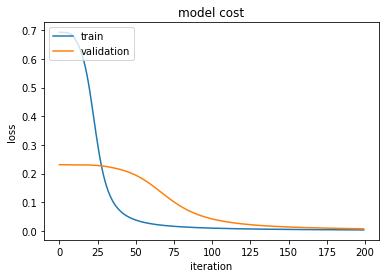

In [216]:
# =========== Setting dataset ================
#N,n_row,n_col,data=read_asc_data('./line600.txt')
N,n_row,n_col,data=read_asc_data('./square_circle.txt')
print('find %d images of %d X %d pixels' % (N,n_row,n_col))
hidden_nodes=3
#plot_data(10,10,n_row,n_col,data)
Nt=int(N*0.6);I=n_row*n_col; #split training vs test sets
Nval=int(N*0.2);
Xt=data[:Nt,:-1];Yt=data[:Nt,-1]
Xval=data[Nt:Nval+Nt,:-1];Yval=data[Nt:Nval+Nt,-1]
Yt = Yt.reshape(len(Yt),1)
Yval=Yval.reshape(len(Yval),1)

np.place(Yt, Yt!=1, [0])
np.place(Yval, Yval!=1, [0])
m = Xt.shape[0]

Xt = Xt.T
Yt = Yt.T
Xval=Xval.T
Yval=Yval.T

print("\nInformation about the dataset : ")
print("We have " + str(np.sum(Yt)) + " images with label = 1 and " + str(Yt.shape[1]-np.sum(Yt)) + " images with label = 0\n")

#funções de ativação disponíveis por agora
# * Relu
# * Tanh
# * Sigmoid
# * Leaky_Relu
activation_function = "tanh"
cache,parameters,cacheval,parametersval = model(hidden_nodes,20000,0.01,activation_function)

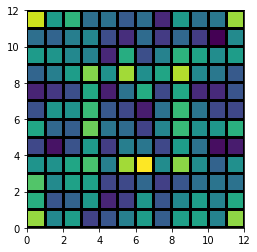

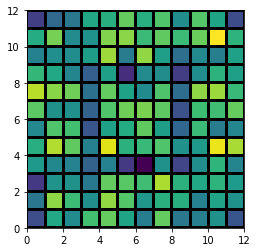

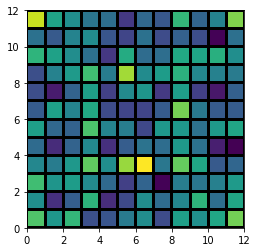

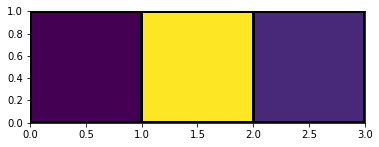

(3, 144)
(1, 3)


In [217]:
#caso os pesos sejam maiores que 0.5 digo que é 1 caso contrário 0
def plot_weights(parameters):
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    
  
    img = w1.reshape(hidden_nodes,12,12)
    plt.ion()
    plt.pcolormesh(img[0], edgecolors='k', linewidth=2)
    ax = plt.gca()
    ax.set_aspect('equal')         
    plt.show(block=True)
    plt.pause(0.001)
    plt.pcolormesh(img[1], edgecolors='k', linewidth=2)
    ax = plt.gca()
    ax.set_aspect('equal')         
    plt.show(block=True)
    plt.pause(0.001)
    plt.pcolormesh(img[2], edgecolors='k', linewidth=2)
    ax = plt.gca()
    ax.set_aspect('equal')         
    plt.show(block=True)
    plt.pause(0.001)
    
    
    plt.ion()
    plt.pcolormesh(w2, edgecolors='k', linewidth=2)
    ax = plt.gca()
    ax.set_aspect('equal')         
    plt.show(block=True)
    plt.pause(0.001)
    
    print(w1.shape)
    print(w2.shape)

plot_weights(parameters)

----------  Confusion matrix on train set with 900 images ------------


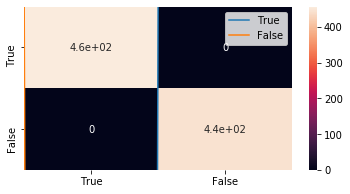

----------  Confusion matrix on test set with 300 ------------


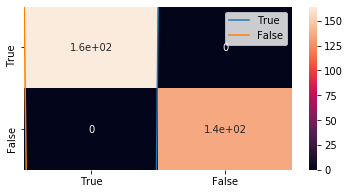

In [221]:
from string import ascii_uppercase
from pandas import DataFrame
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

def my_confusion_matrix(parameters):
    
    Ne=N-Nt;
    Xe=data[Nt+Nval:N,:-1];Ye=data[Nt+Nval:N,-1]; 
    Ye = np.where(Ye == -1, 0,1)
    Xe = Xe.T; Ye = Ye.T #test set
    
    #Xt,Yt -> train set
    
    predictions_train_set , _ = feed_forward(Xt,parameters,activation_function)
    predictions_test_set , _ = feed_forward(Xe,parameters,activation_function)
    predictions_train_set = np.where(predictions_train_set < 0.5 , 0 , 1) 
    predictions_test_set = np.where(predictions_test_set < 0.5 , 0 , 1) 
    
    labels = [0,1]
    columns = ['True','False']
    
    print("----------  Confusion matrix on train set with " + str(Yt.shape[1]) + " images ------------")
    
    #data
    y_test = Yt.T
    predic = predictions_train_set.T

    #confusion matrix
    confm = confusion_matrix(y_test, predic,labels)
    #confusion matrix to datafram
    df_cm = DataFrame(confm, index=columns, columns=columns)
    df_cm.plot(figsize=(6,3));
    
    #plot
    ax = sn.heatmap(df_cm, annot=True)
    plt.show()
    #same thing on test set
    print("----------  Confusion matrix on test set with " + str(Ye.shape[0]) + " ------------")
    y_test = Ye.T
    predic = predictions_test_set.T
    
    confm = confusion_matrix(y_test, predic)
    df_cm = DataFrame(confm, index=columns, columns=columns)
    df_cm.plot(figsize=(6,3));
    ax = sn.heatmap(df_cm, annot=True)
    
my_confusion_matrix(parameters)

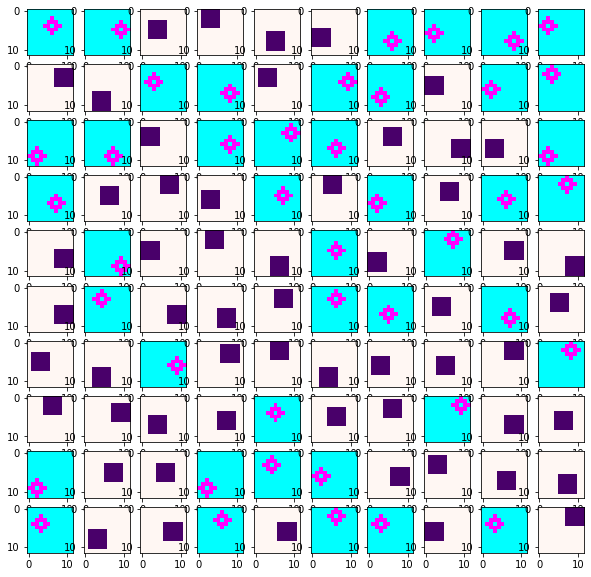

In [219]:
Ne=N-Nt;
Xe=data[Nt:N,:-1];Ye=data[Nt:N,-1];
Ye = np.where(Ye == -1, 0,1)
plot_tagged_data(10,10,n_row,n_col,Xe,Ye,parameters)

In [220]:
0.002 * 100

0.2